In [ ]:
pip install skorch


In [2]:
#Data Oreprocessing

In [43]:
import torch
import pandas as pd
import numpy as np
import joblib
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
import torch.optim as optim
from sklearn.model_selection import GridSearchCV

In [44]:
data = pd.read_csv('lending_club_l.csv')
data.head()



,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [45]:
data.shape
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [46]:
data.describe()


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [47]:
# Display data types and check for missing values
data_types = data.dtypes
print("Data Types:\n", data_types)


Data Types:
 loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
address                  object
dtype: object


In [48]:
# List of columns to drop
columns_to_drop = [
    'emp_title',           # High cardinality text field, often dropped or encoded differently
    'issue_d',             # Date feature might need transformation, but often dropped
    'title',               # Often similar to 'purpose', could be redundant
    'earliest_cr_line',    # Date feature, may need transformation if not directly used
    'address'              # Typically not useful unless specific features are extracted
]

# Drop the columns
data = data.drop(columns=columns_to_drop)

# Verify the remaining columns
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_length            377729 non-null  object 
 7   home_ownership        396030 non-null  object 
 8   annual_inc            396030 non-null  float64
 9   verification_status   396030 non-null  object 
 10  loan_status           396030 non-null  object 
 11  purpose               396030 non-null  object 
 12  dti                   396030 non-null  float64
 13  open_acc              396030 non-null  float64
 14  pub_rec               396030 non-null  float64
 15  

In [49]:
print(data['loan_status'].unique())

['Fully Paid' 'Charged Off']


In [50]:
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64


In [51]:
# Remove rows with missing values in 'emp_length'
data = data.dropna(subset=['emp_length'])

# Impute missing values for 'revol_util', 'mort_acc', and 'pub_rec_bankruptcies' with the median
data['revol_util'].fillna(data['revol_util'].median(), inplace=True)
data['mort_acc'].fillna(data['mort_acc'].median(), inplace=True)
data['pub_rec_bankruptcies'].fillna(data['pub_rec_bankruptcies'].median(), inplace=True)

# Verify that there are no more missing values
missing_values_after = data.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after)



Missing Values After Imputation:
 loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64


In [52]:
print(data.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')


In [53]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 377729 entries, 0 to 396029
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             377729 non-null  float64
 1   term                  377729 non-null  object 
 2   int_rate              377729 non-null  float64
 3   installment           377729 non-null  float64
 4   grade                 377729 non-null  object 
 5   sub_grade             377729 non-null  object 
 6   emp_length            377729 non-null  object 
 7   home_ownership        377729 non-null  object 
 8   annual_inc            377729 non-null  float64
 9   verification_status   377729 non-null  object 
 10  loan_status           377729 non-null  object 
 11  purpose               377729 non-null  object 
 12  dti                   377729 non-null  float64
 13  open_acc              377729 non-null  float64
 14  pub_rec               377729 non-null  float64
 15  revol

In [54]:
#Data transforming

In [55]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define the nominal features that are present in your DataFrame, including 'home_ownership'
nominal_features = ['term', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership']

# Perform OneHotEncoding on the nominal features
data = pd.get_dummies(data, columns=nominal_features, drop_first=True)

# Verify the encoding
encoded_columns = data.columns
print("\nEncoded Columns:\n", encoded_columns)



Encoded Columns:
 Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'term_ 60 months',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'initial_list_status_w',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')


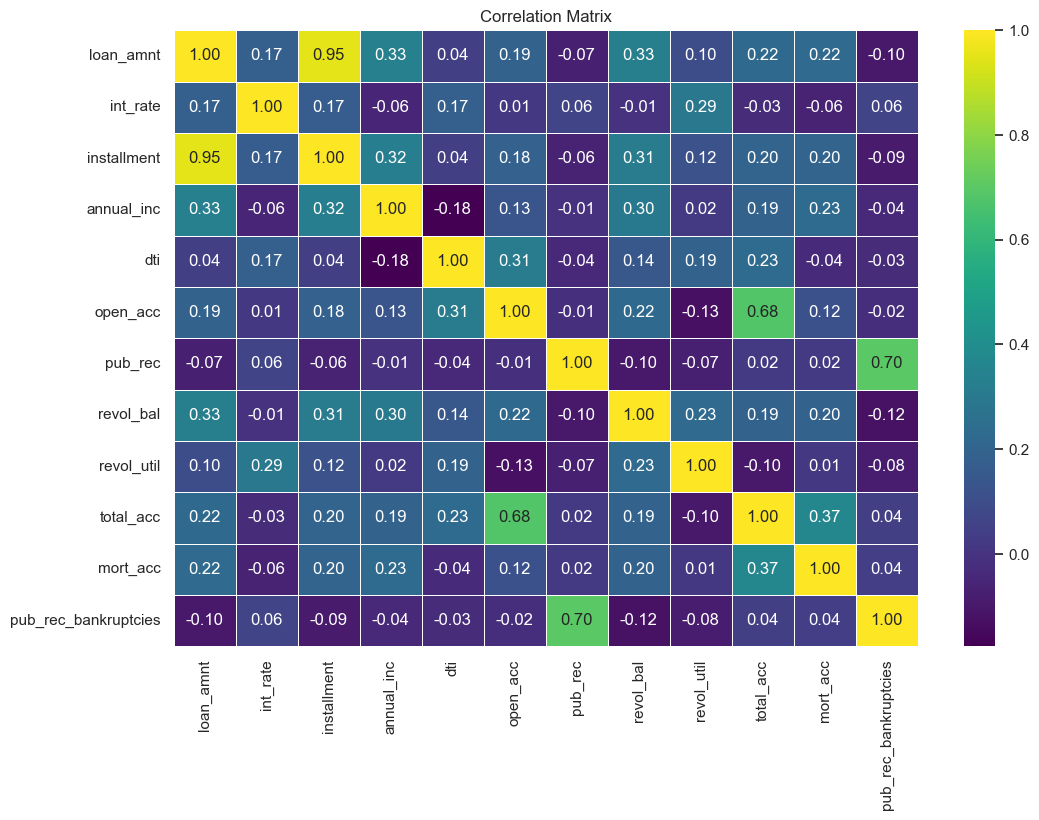

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()


In [58]:
# Define the function to create the target variable
def map_loan_status(status):
    if status in ['Charged Off', 'Default']:
        return 1
    elif status == 'Fully Paid':
        return 0
    else:
        return None  # We'll drop rows with statuses other than 'Fully Paid' and 'Charged Off'/'Default'

# Apply the function to create the target variable
data['loan_default'] = data['loan_status'].apply(map_loan_status)

# Drop rows with None values in 'loan_default' column
data = data.dropna(subset=['loan_default'])

# Drop the original loan_status column as it is no longer needed
data = data.drop(columns=['loan_status'])

# Verify the distribution of the target variable
target_distribution = data['loan_default'].value_counts()
print("\nTarget Variable Distribution:\n", target_distribution)



Target Variable Distribution:
 loan_default
0    305094
1     72635
Name: count, dtype: int64


In [83]:
data_cleaned = data.dropna()
data_encoded = pd.get_dummies(data_cleaned, drop_first=True)


In [84]:
from sklearn.preprocessing import StandardScaler

# List of numerical features to be standardized
numerical_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                      'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                      'mort_acc', 'pub_rec_bankruptcies']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Verify the scaling
scaled_data_sample = data[numerical_features].head()
print("\nScaled Data Sample:\n", scaled_data_sample)



Scaled Data Sample:
    loan_amnt  int_rate  installment  annual_inc       dti  open_acc  pub_rec  \
0  -0.508175 -0.490530    -0.422574    0.667509  1.103592  0.900170 -0.32851   
1  -0.746983 -0.367606    -0.676528   -0.166864  0.587215  1.094460 -0.32851   
2   0.160485 -0.702852     0.283921   -0.518954 -0.553992  0.317299 -0.32851   
3  -0.842506 -1.596842    -0.855769   -0.343366 -1.809813 -1.042733 -0.32851   
4   1.208253  0.812460     0.691362   -0.327321  2.053777  0.317299 -0.32851   

   revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies  
0   0.985751   -0.497223  -0.039592 -0.842167             -0.333836  
1   0.200988   -0.026380   0.128675  0.620659             -0.333836  
2  -0.192602    1.566298   0.044542 -0.842167             -0.333836  
3  -0.507464   -1.328363  -1.049193 -0.842167             -0.333836  
4   0.416196    0.649178   1.474811 -0.354559             -0.333836  


In [85]:
#EDA

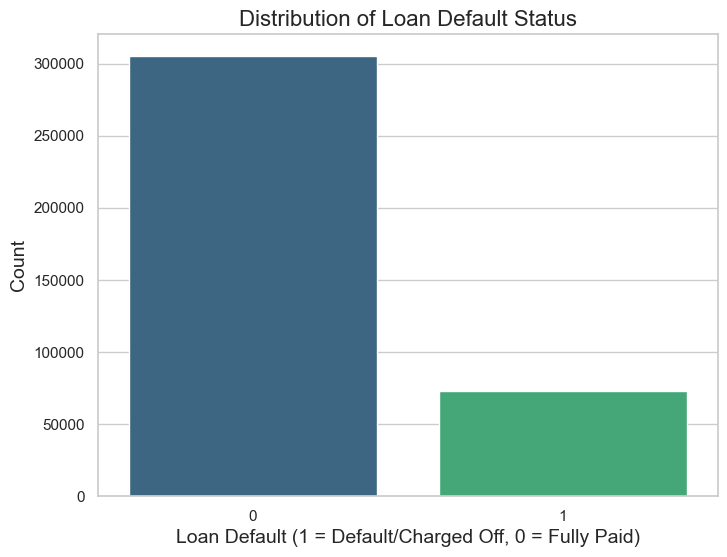

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_default', data=data, palette='viridis')

# Add title and labels
plt.title('Distribution of Loan Default Status', fontsize=16)
plt.xlabel('Loan Default (1 = Default/Charged Off, 0 = Fully Paid)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()


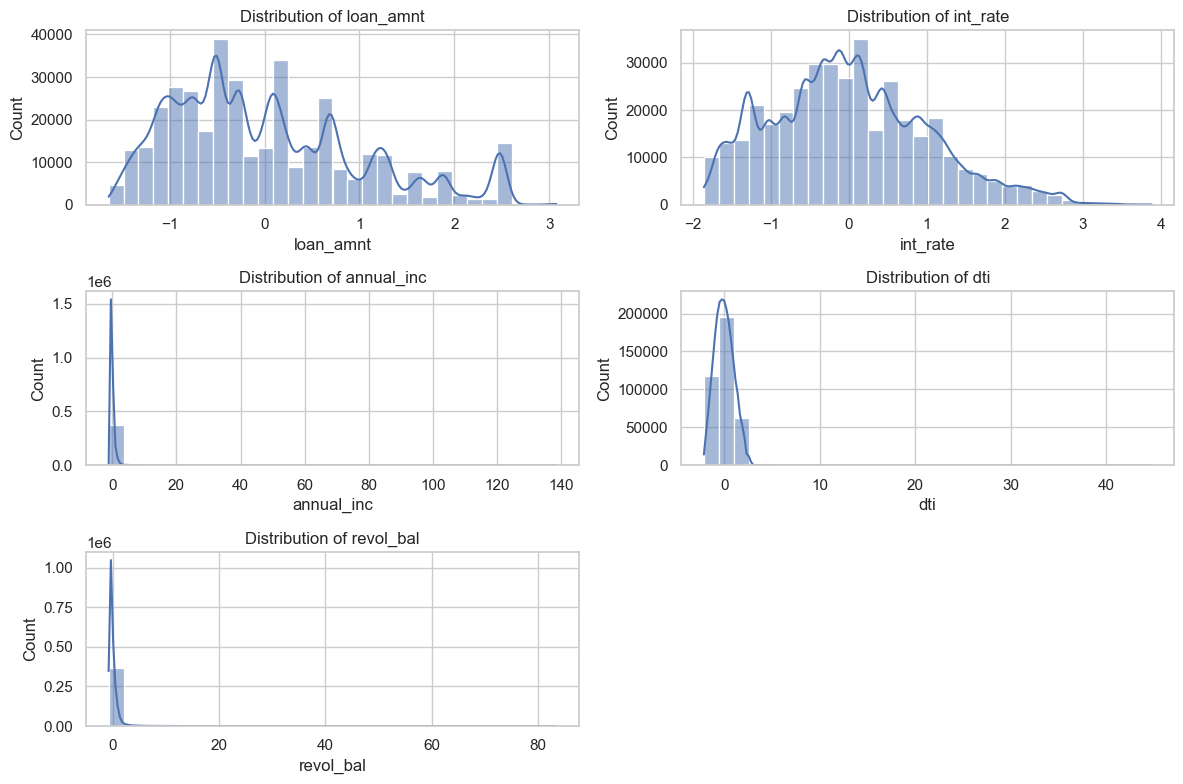

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style='whitegrid')

# Plot the distribution of key numerical features
key_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



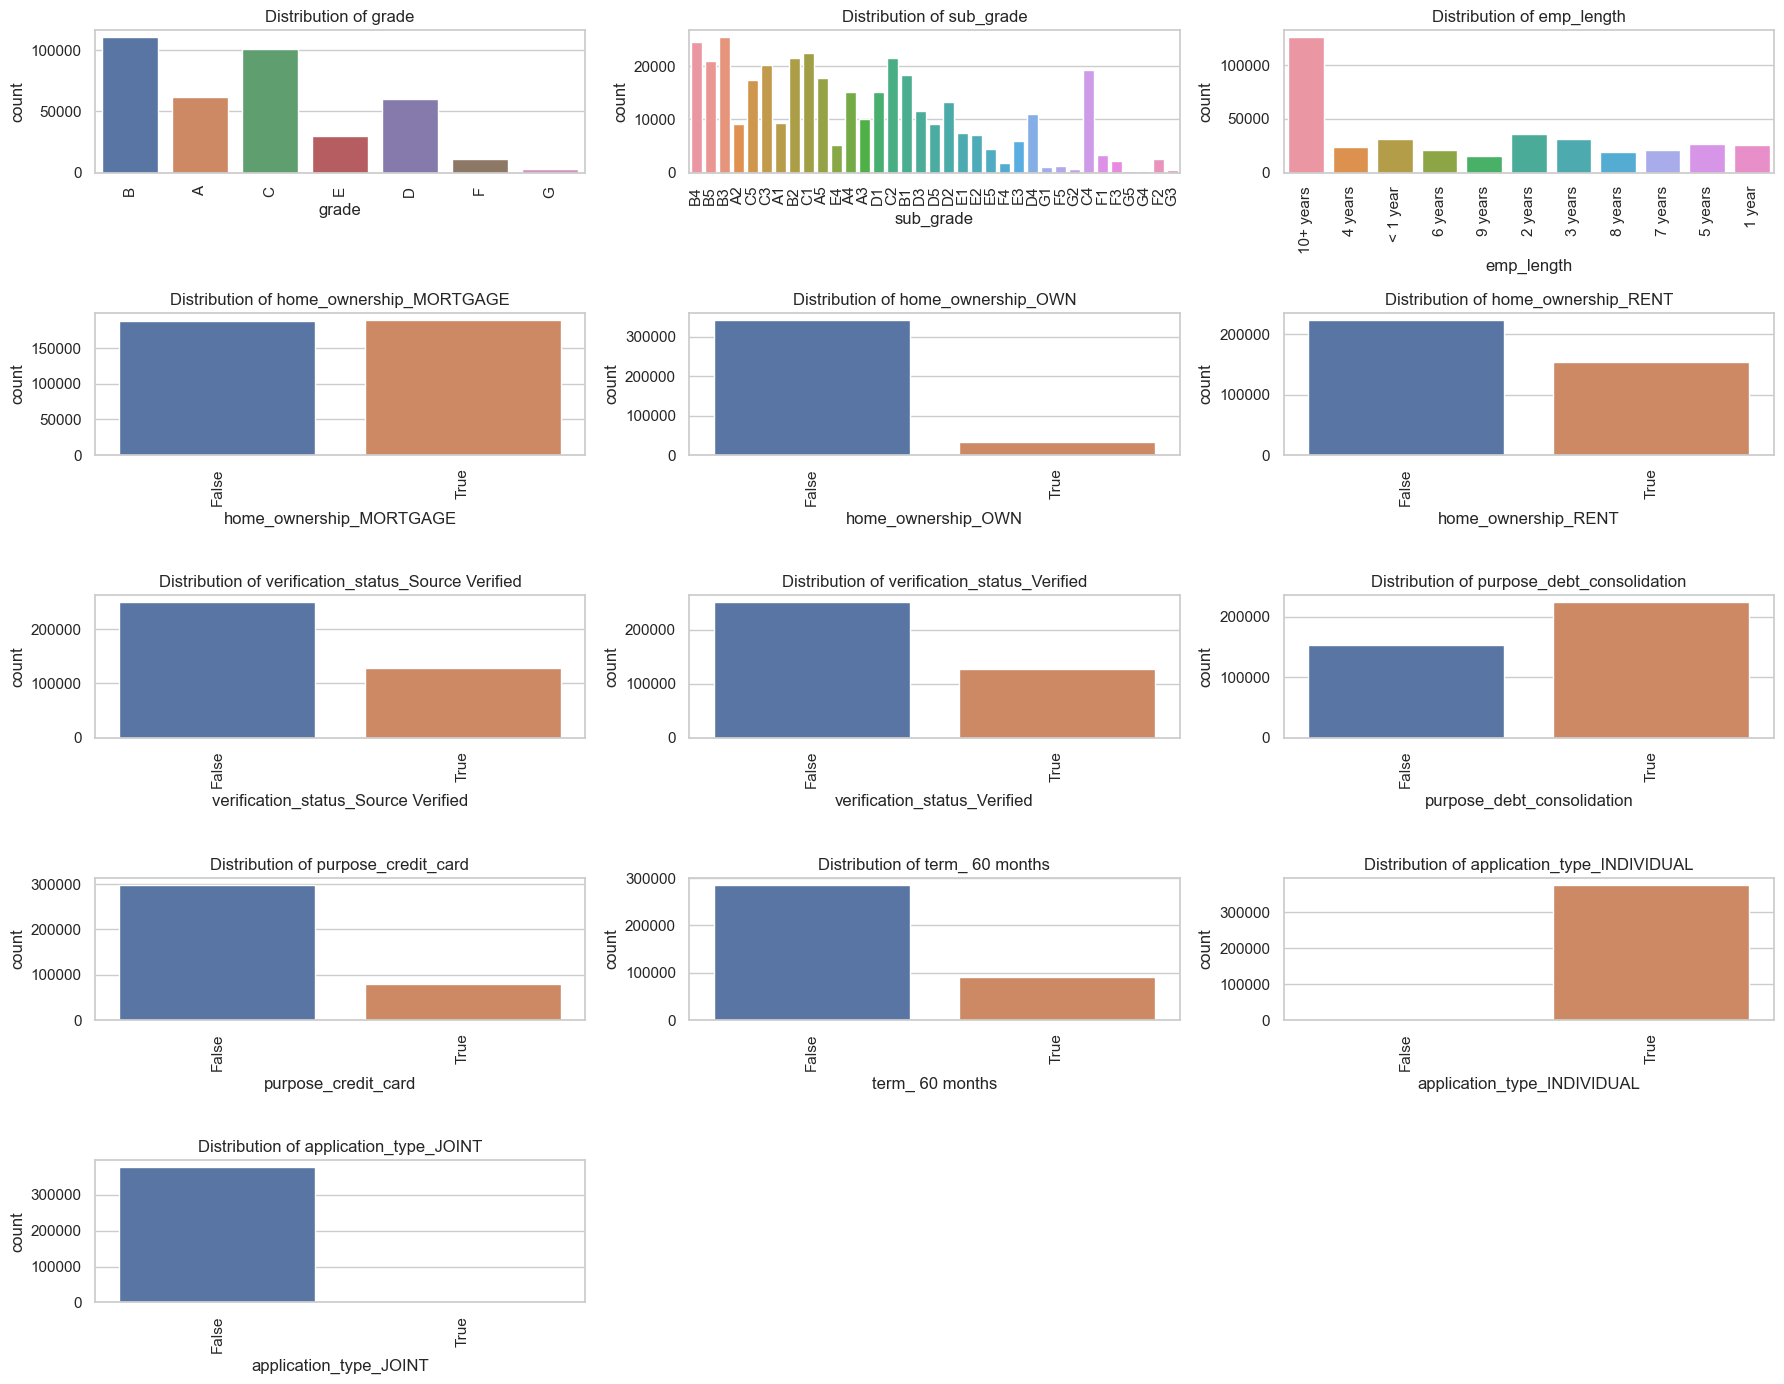

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust categorical features list to match one-hot encoded columns
categorical_features = ['grade', 'sub_grade', 'emp_length', 
                        'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
                        'verification_status_Source Verified', 
                        'verification_status_Verified', 
                        'purpose_debt_consolidation', 
                        'purpose_credit_card',
                        'term_ 60 months', 
                        'application_type_INDIVIDUAL', 
                        'application_type_JOINT']

# Increase the grid size to fit 13 subplots
plt.figure(figsize=(18, 14))  # Adjust figure size to fit more plots
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(5, 3, i)  # 5 rows and 3 columns to accommodate 15 plots
    sns.countplot(data=data, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [67]:
# Check for non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
print("\nNon-Numeric Columns:\n", non_numeric_columns)

# Example: Check unique values of one of the encoded columns instead
if 'home_ownership_MORTGAGE' in data.columns:
    print(data['home_ownership_MORTGAGE'].unique())
else:
    print("'home_ownership' has been encoded into multiple columns.")

# If you want to see all columns after encoding
print("\nAll Columns in Data:\n", data.columns)



Non-Numeric Columns:
 Index(['grade', 'sub_grade', 'emp_length'], dtype='object')
[False  True]

All Columns in Data:
 Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies',
       'term_ 60 months', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'initial_list_status_w',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       '

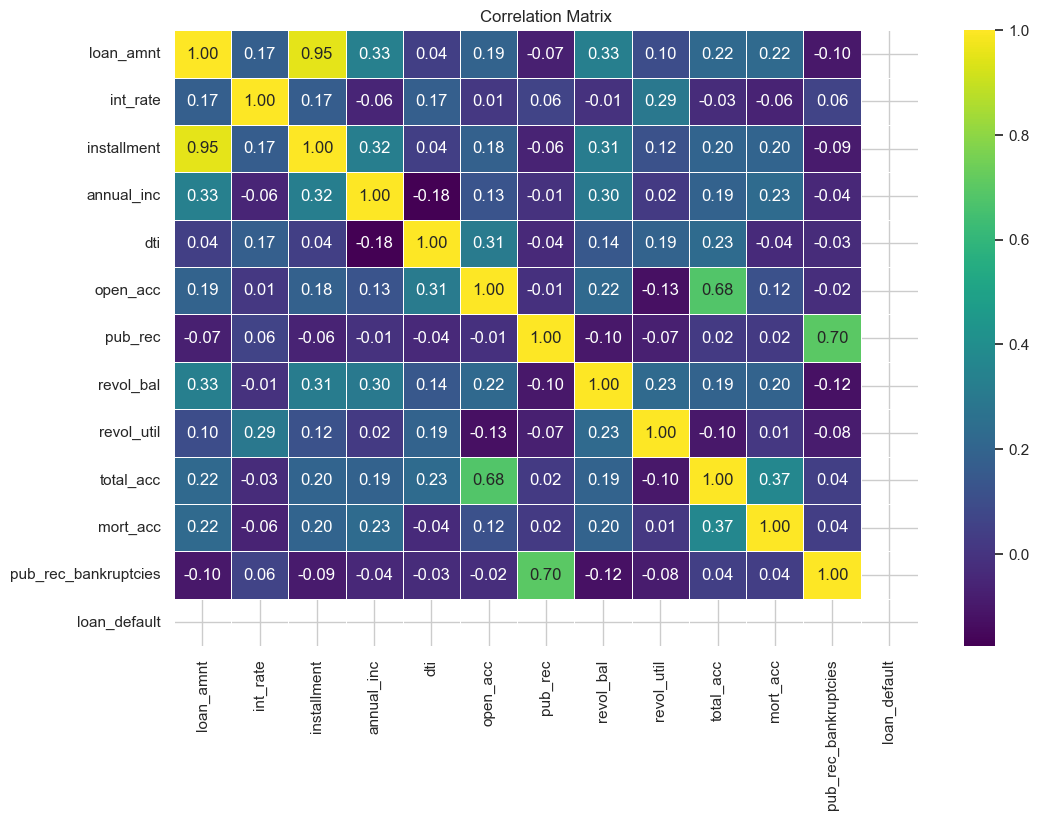

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the correlation matrix
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()


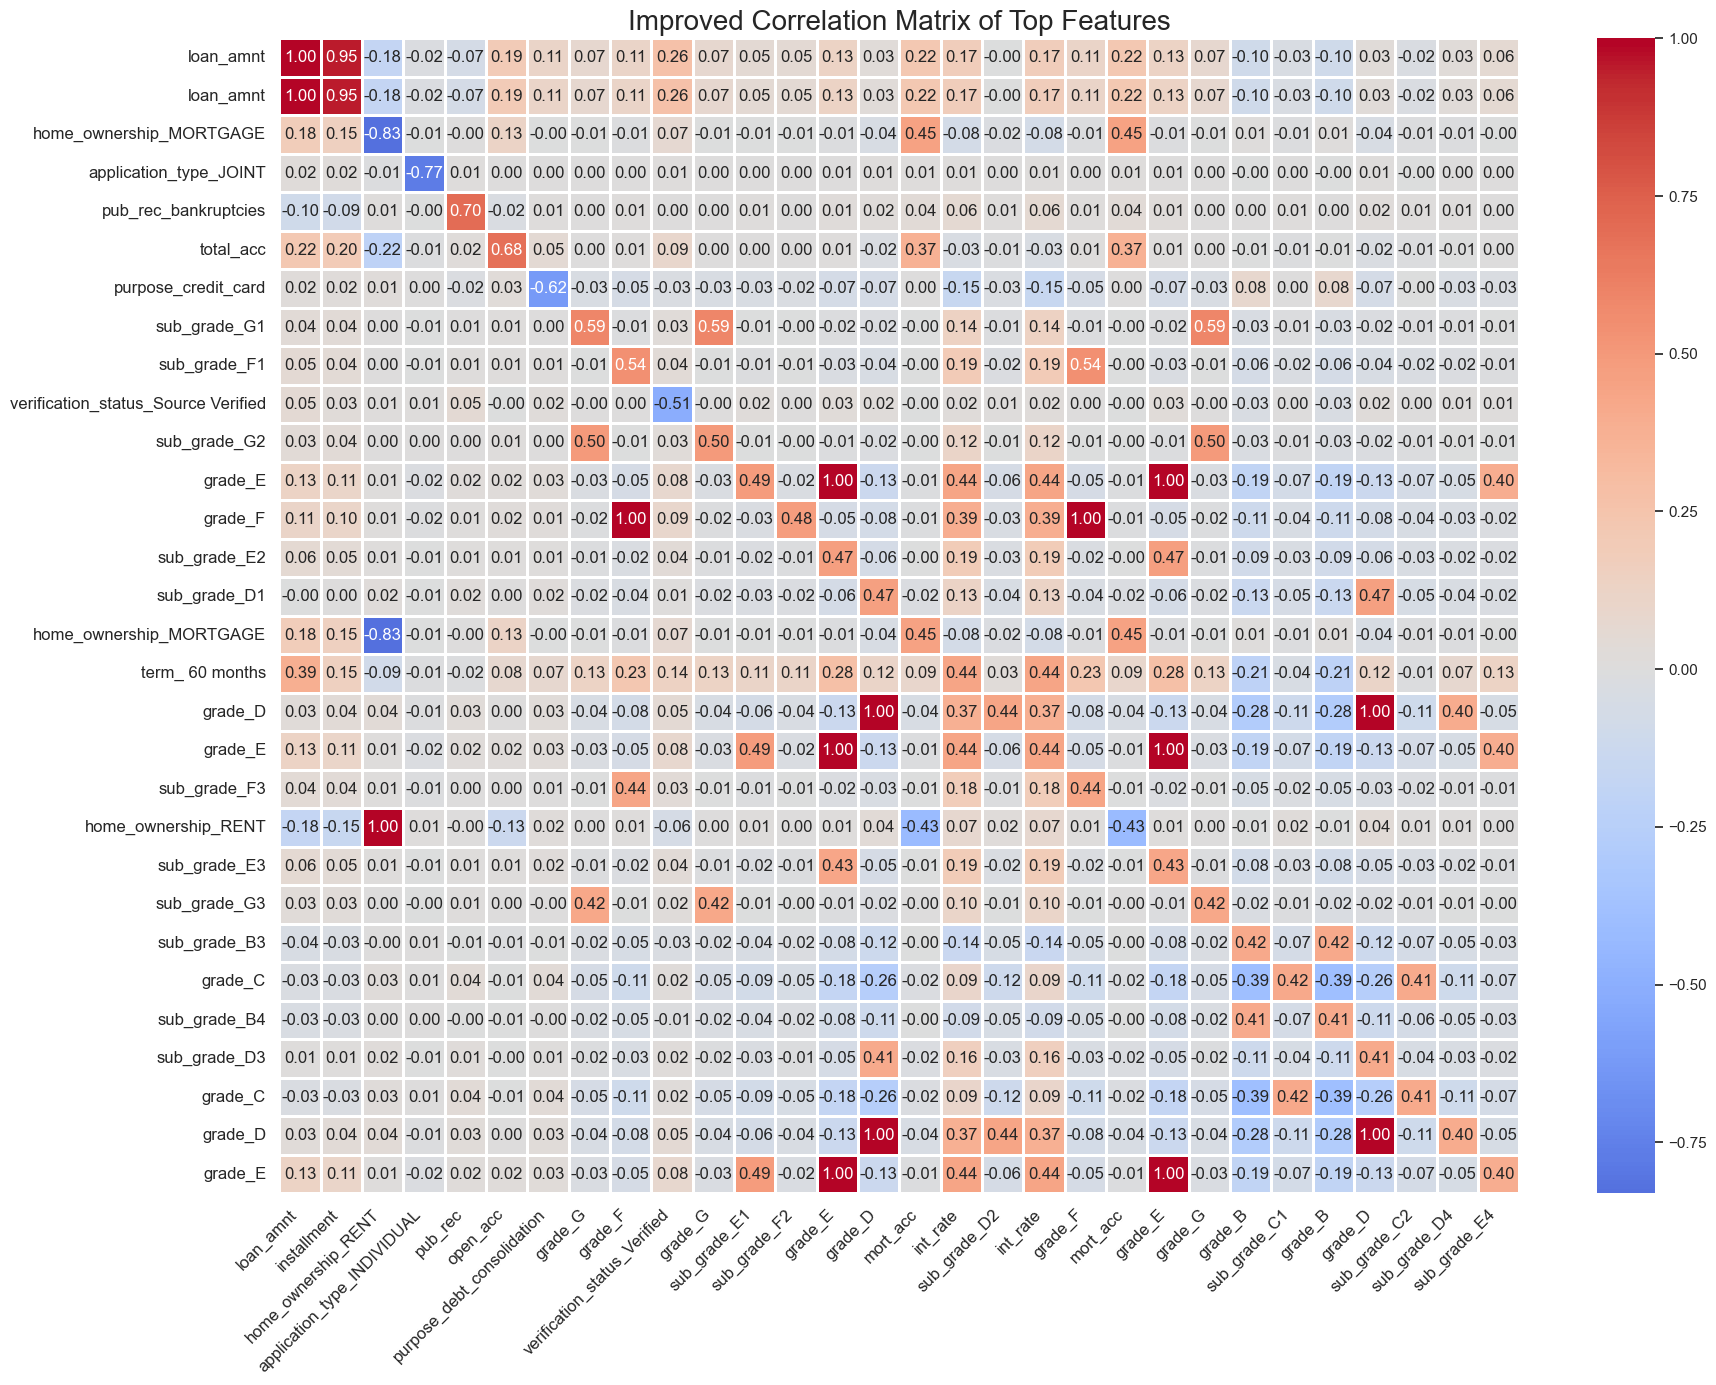

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size to make it more readable
plt.figure(figsize=(20, 15))

# Draw the heatmap with the correlation matrix, focusing on top features (e.g., top 30 by correlation)
corr_matrix_filtered = correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates().head(30)
top_corr_matrix = correlation_matrix.loc[corr_matrix_filtered.index.get_level_values(0), corr_matrix_filtered.index.get_level_values(1)]

sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=1, center=0)

# Set title and improve label readability
plt.title('Improved Correlation Matrix of Top Features', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()


In [89]:
print(len(data.columns))

40


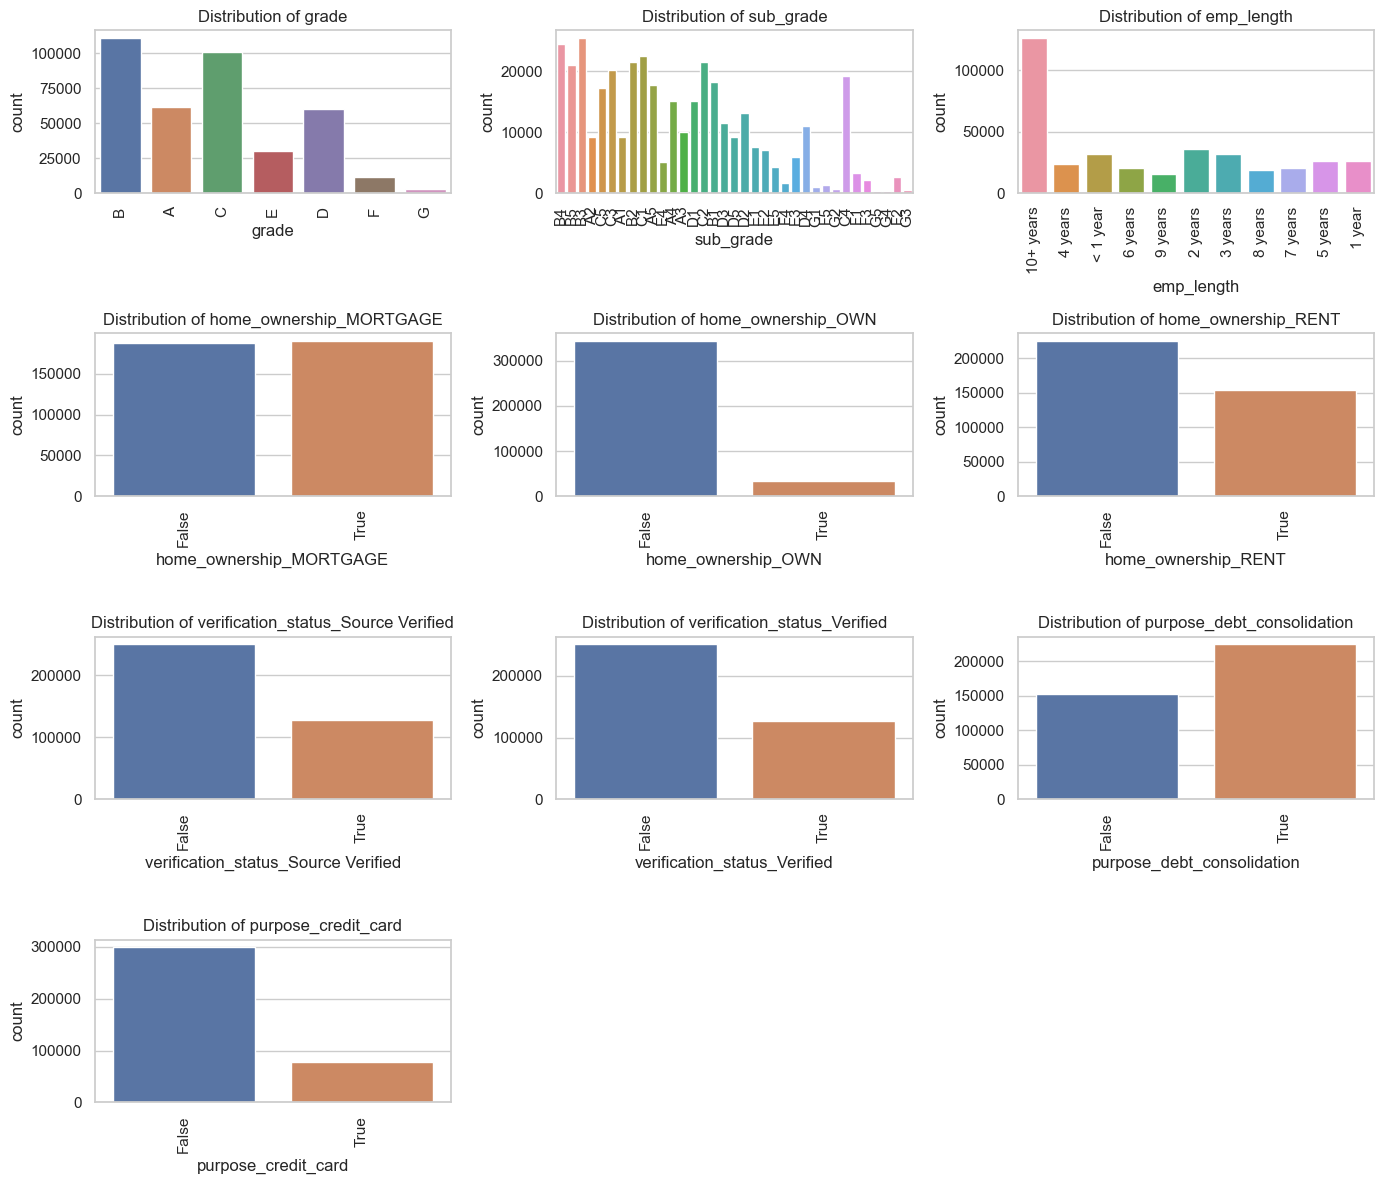

In [91]:
# Adjust categorical features list to match one-hot encoded columns
categorical_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
                        'verification_status_Source Verified', 'verification_status_Verified', 'purpose_debt_consolidation', 'purpose_credit_card']

plt.figure(figsize=(14, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=data, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/Users/prachib/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


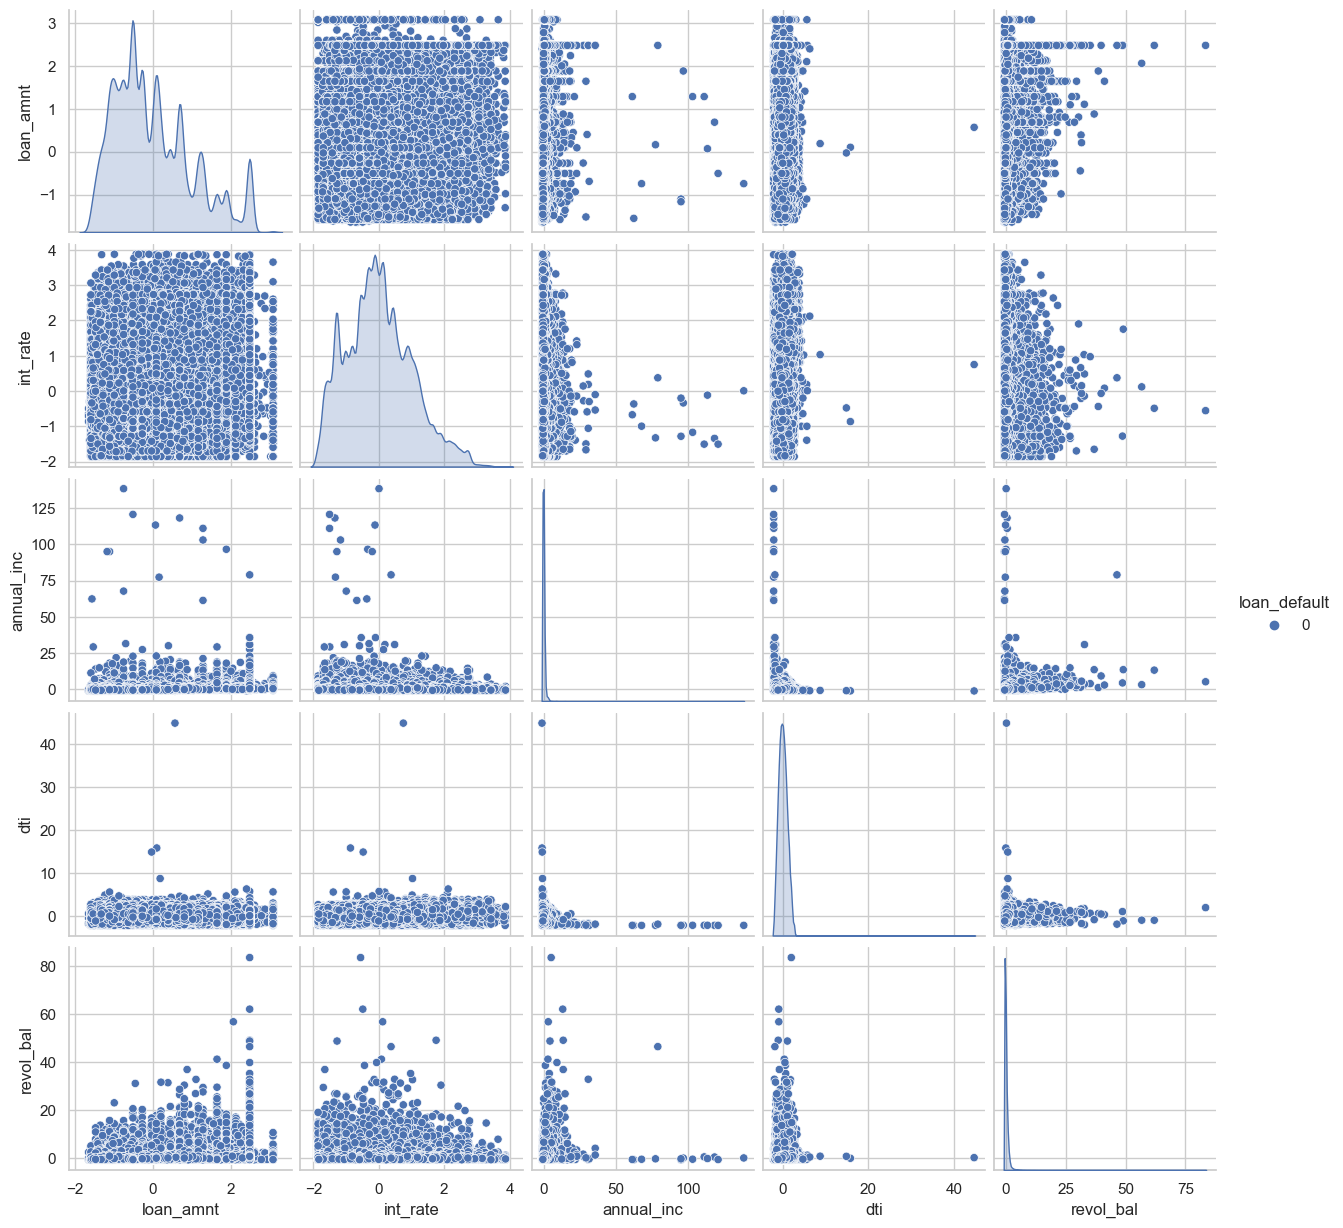

In [92]:
# Select a subset of features for pairplot to avoid too much computation
selected_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'loan_default']

# Plot pairplot
sns.pairplot(data[selected_features], hue='loan_default', diag_kind='kde')
plt.show()


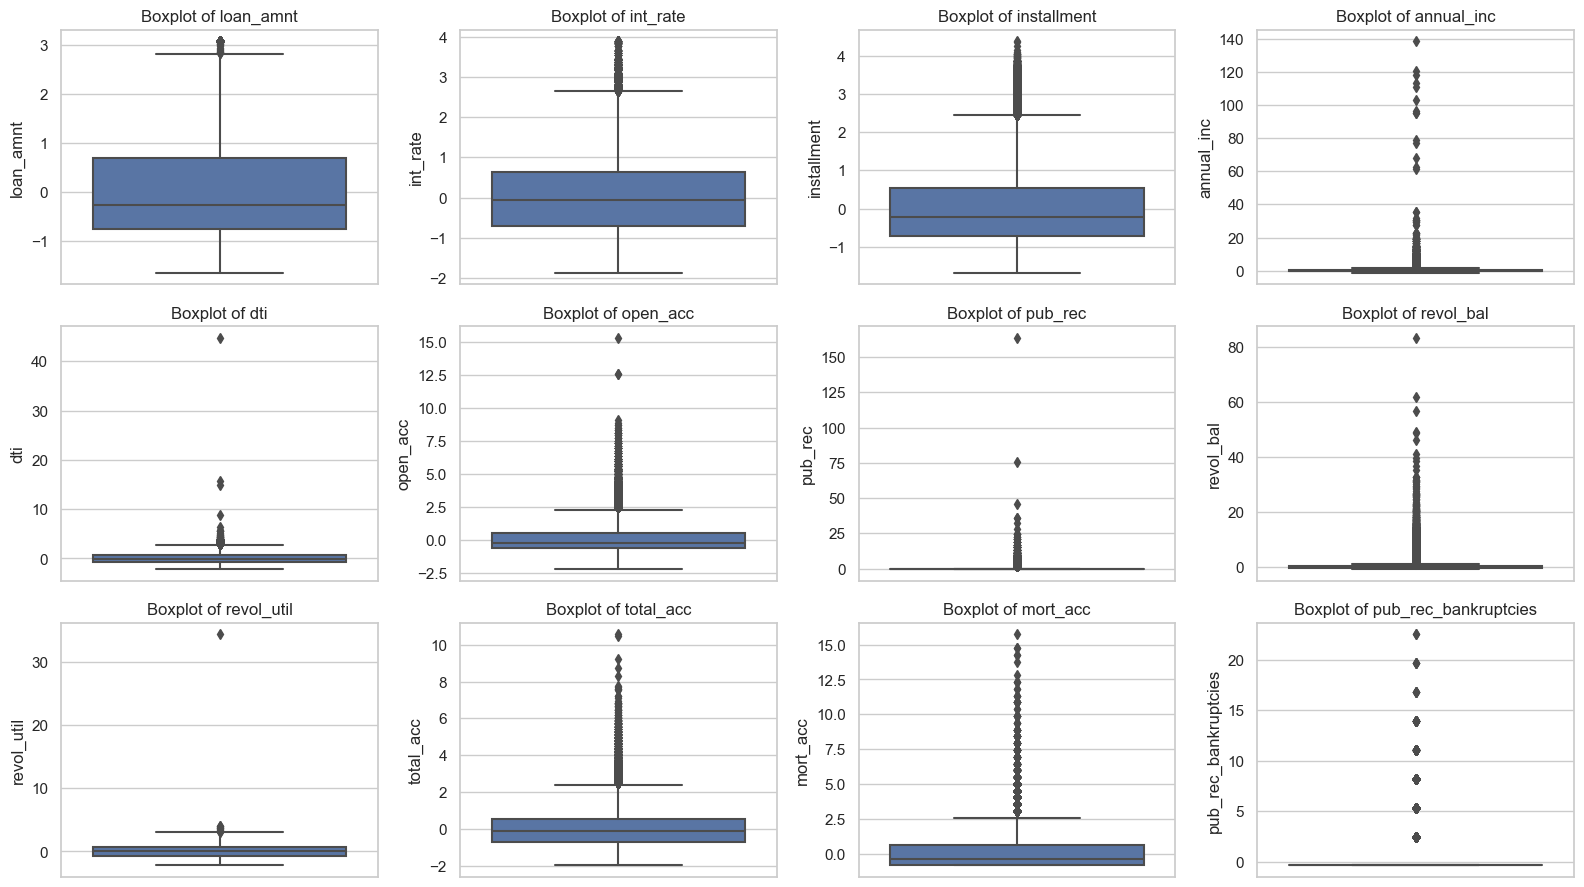

In [93]:
# Visualize distributions and detect outliers in numerical features using box plots
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=data, y=feature)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()



In [104]:
#Models

In [122]:
# Perform the stratified train-test split
X = data.drop(columns=['loan_default'])
y = data['loan_default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Check the target distribution again after the split
print("Training set target distribution:")
print(y_train.value_counts())
print("Test set target distribution:")
print(y_test.value_counts())


Training set target distribution after adjusting split:
loan_default
0    302183
Name: count, dtype: int64
SMOTE cannot be applied as the training set contains only one class.


In [117]:
# Ensure all categorical features are encoded
nominal_features = ['grade', 'sub_grade', 'emp_length']  # Add any other non-encoded categorical features

# Perform OneHotEncoding on the nominal features
data = pd.get_dummies(data, columns=nominal_features, drop_first=True)

# Verify all features are numeric
print(data.dtypes)


loan_amnt              float64
int_rate               float64
installment            float64
annual_inc             float64
dti                    float64
                        ...   
emp_length_6 years        bool
emp_length_7 years        bool
emp_length_8 years        bool
emp_length_9 years        bool
emp_length_< 1 year       bool
Length: 87, dtype: object


In [119]:
# Convert boolean features to integers (0 and 1)
X = X.astype(int)

# Verify the conversion
print(X.dtypes)


loan_amnt              int64
int_rate               int64
installment            int64
annual_inc             int64
dti                    int64
                       ...  
emp_length_6 years     int64
emp_length_7 years     int64
emp_length_8 years     int64
emp_length_9 years     int64
emp_length_< 1 year    int64
Length: 86, dtype: object


In [121]:
# Check the distribution of the target variable in the training set
print("Training set target distribution before SMOTE:")
print(y_train.value_counts())


Training set target distribution before SMOTE:
loan_default
0    264410
Name: count, dtype: int64


In [126]:
print("Original dataset target distribution:")
print(data['loan_default'].value_counts())


Original dataset target distribution:
loan_default
0    377729
Name: count, dtype: int64


In [127]:
# Check if the minority class exists
if len(data_minority) > 0:
    # Upsample minority class
    data_minority_upsampled = resample(
        data_minority,
        replace=True,  # sample with replacement
        n_samples=len(data_majority),  # to match majority class
        random_state=42
    )

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

    # Split the upsampled dataset
    X = data_upsampled.drop(columns=['loan_default'])
    y = data_upsampled['loan_default']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Now you can proceed with training your model
    print("Training set target distribution after upsampling:")
    print(y_train.value_counts())
else:
    print("Minority class (loan_default = 1) is missing or empty.")


Minority class (loan_default = 1) is missing or empty.
